In [110]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import sympy as sm
import func
import time
%reload_ext line_profiler

In [111]:
def utility(c,theta):
    ''' Utility function for consumption including the limit case for rho->1 '''
    '''not actually used because direct calculation is faster'''
    if c<0:
        raise error
    if rho !=1 :
        return (c**(1-theta)-1)/(1-theta)
    else:
        return np.log(c)

def total_utility(c, weight, theta):
    '''
    Sums utility for c for multiple years
    c is an array 
    '''
    uts = (c**(1-theta)-1)/(1-theta)
    # sum of utitity
    t_u = np.dot(uts,weight)
    
    return t_u

def prod(k,l,alpha,b):
    return (b*k**alpha)*(l**(1-alpha))

assert np.allclose(total_utility1(c, beta, theta),total_utility2(c, beta, theta))

times = 500000
def loop1(times):
    for i in range(times):
        total_utility1(c, beta, theta)
        
def loop2(times):
    for i in range(times):
        total_utility2(c, beta, theta)

%lprun -f total_utility1 -f loop1 loop1(times)

%lprun -f total_utility2 -f loop2 loop2(times)

In [112]:
def tot_ut_sk(sk,t, k0, l, b, weight, alpha, theta, delta, quick=True):
    '''
    Returns utitlity for  given period 
    depending on initial amount of kapital, k0,
    and a fixed savingsrate, sk, for all periods 
    '''
    k_short = np.empty(t)
    c_short = np.empty(t)
    y_short = np.empty(t)
    k_short[0] = k0
    for i in range(t):
        y_short[i] = prod(k_short[i],l[i],alpha,b)
        c_short[i]=(1-sk)*y_short[i]
        if i+1<t:
            k_short[i+1]=sk*y_short[i]+(1-delta)*k_short[i] 
    if quick:
        return total_utility(c_short,weight,theta)
    else:
        return k_short,c_short,y_short

def opt_sk(t, b, weight, delta, alpha, theta, k0,l):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, weight, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

# Fast opsparingsrate

analytisk

In [ ]:
sm.init_printing(use_unicode=True)

In [ ]:
#valgmuligheder:
# andelen af mulig arbejdstid som bruges på forskning:
sr = sm.symbols('s_Rt')
# I starten antages kapitalopspsparingsraten at være konstant
sk = sm.symbols('s_Kt')
# Ud fra de valg nogle udfald
# Først defineres variable
l = sm.symbols('L_{t}')
ly = sm.symbols('L_{Yt}')
la = sm.symbols('L_{At}')
alpha = sm.symbols('alpha')
k =sm.symbols('K_{t}')
k1 = sm.symbols('K_{t+1}')
y = sm.symbols('Y_{t}')
c = sm.symbols('C')
ct = sm.symbols('C_{t}')
a = sm.symbols('A_{t}')
a1 = sm.symbols('A_{t+1}')
r = sm.symbols('r')

#Greek:
rho = sm.symbols('rho')
beta = sm.symbols('beta')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
theta = sm.symbols('theta')

t = sm.symbols('t')
ts = sm.symbols('T')
# Functions:
uc = sm.Function('u')(ct) 
u = sm.Function('U')(c)

In [ ]:
sm.Eq(uc,(ct**(1-theta)-1)/(1-theta))

In [ ]:
sm.Eq(u,sm.Sum(beta**t*(ct**(1-theta)-1)/(1-theta),(t,0,ts)))

In [ ]:
sm.init_printing(use_unicode=False)

Nummerisk

In [114]:
theta = 0.5
alpha = 1/3
delta = 0.05
rho = 0.5
n=0.008

In [116]:
t = 100
b = 10
k0 = 10
l = [(1+n)**i for i in range(t)]
beta = 0.9
weight = np.array([beta**i for i in range(t)])
c = np.random.normal(100,1,t)
sks  = alpha

In [117]:
tot_ut_sk(sks,t, k0, l, b, weight, alpha, theta, delta, quick=True)

86.6439635467891

In [119]:
n = 100
ks = np.linspace(0.0001,300,n)
sks = np.zeros(n)
for i,k in enumerate(ks):
    sks[i] = opt_sk(t, b, weight,delta,alpha,theta,k,l)

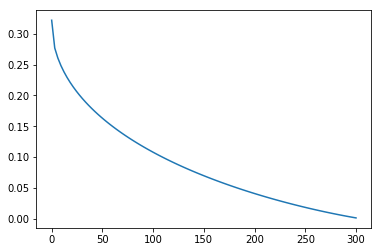

In [120]:
func.plot(ks,sks)

# Need speed?

In [35]:
def opt_sk1(t, b, weight, delta, alpha, theta, k0, l):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, weight, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

In [37]:
def loop1(n):
    for i in range(n):
        opt_sk1(t, b, beta, delta, alpha, theta, k0,l)

In [38]:
%lprun -f opt_sk1 -f loop1 loop1(n)

Timer unit: 1e-06 s

Total time: 0.715449 s
File: <ipython-input-35-dc2ccc10dfc5>
Function: opt_sk1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opt_sk1(t, b, beta, delta, alpha, theta, k0, l):
     2                                               '''Finds optimal fixed savings rate, sk, 
     3                                               for maximal total utility '''
     4       100        182.0      1.8      0.0      obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, beta, alpha, theta, delta)
     5       100     714520.0   7145.2     99.9      res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
     6       100        747.0      7.5      0.1      return res.x

Total time: 0.716467 s
File: <ipython-input-37-186312989a80>
Function: loop1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def loop1(n):
     2       10

# Varierende opsparingsrate

In [122]:
def tot_ut_multiple_sks(sks, k0, l, b, weight, theta, alpha, delta, simple=True):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1],alpha,b)+(1-delta)*k_short[i-1]
    
    y_short = prod(k_short,l,alpha,b)
    if simple:
        return total_utility(y_short*(1-sks)/l, weight, theta)
    else:
        return total_utility(y_short*(1-sks)/l, weight, theta), y_short, y_short*(1-sks), k_short

In [121]:
def tot_ut_multiple_sks_quick(sks, k0, l, b, weight, theta, alpha, delta):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1],alpha,b)+(1-delta)*k_short[i-1]
    
    y_short = prod(k_short,l,alpha,b)
    
    return total_utility(y_short*(1-sks)/l, weight, theta)

In [124]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
n = 0.01
b = 10
k0 = 1
l0 = 1



In [126]:
t = 50
l = np.array([l0*(1+n)**i for i in range(t)])
weight = np.array([beta**i for i in range(t)])

obj = lambda sks: -tot_ut_multiple_sks_quick(sks, k0, l, b, weight, theta, alpha, delta)
sks0 = np.full(t,alpha)
sks0[-1] = 0
bounds = np.full((t,2),[0,1])


res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)

print(f'Optimal sk')
np.set_printoptions(precision=4,suppress=True)
print(res.x)
print('Total utility:')
print(f'{-res.fun:.4f}')

Optimal sk
[0.6309 0.6264 0.6028 0.5775 0.5537 0.5323 0.5127 0.4949 0.4787 0.4637
 0.4498 0.4369 0.4247 0.4132 0.4022 0.3918 0.3816 0.3717 0.362  0.3524
 0.3428 0.3331 0.3232 0.3132 0.3028 0.2919 0.2806 0.2685 0.2555 0.2414
 0.226  0.2092 0.1905 0.1695 0.1457 0.1184 0.0866 0.049  0.004  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Total utility:
218.9665


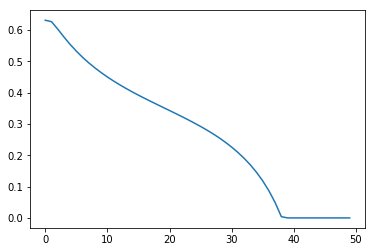

In [127]:
func.plot(range(t),res.x)

In [128]:
def optimal_sks(t, b, l, weight, delta, alpha, theta, k0, first=True):
    obj = lambda sks: -tot_ut_multiple_sks_quick(sks, k0, l, b, weight, theta, alpha, delta)
    sks0 = np.linspace(alpha,0,t)

    bounds = np.full((t,2),[0,1])
    res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
    if res.success == False:
        print('Optimization was sadly not succesfull')
    elif first:
        return res.x[0]
    else:
        return res.x

In [134]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 2
n = 0.01
beta = 0.99
k0 = 20
l0 = 1
t = 60
l = np.array([l0*(1+n)**i for i in range(t)])
weight = np.array([beta**i for i in range(t)])

In [136]:
sks = optimal_sks(t, b, l, weight, delta, alpha, theta, k0, first=False)
total, y, c, k = tot_ut_multiple_sks(sks, k0, l, b, weight, theta, alpha, delta, simple=False)

In [139]:
sks_alt = np.array([alpha for i in list(range(t))])
total_alt, y_alt, c_alt, k_alt = tot_ut_multiple_sks(sks_alt, k0, l, b, weight, theta, alpha, delta, simple=False)

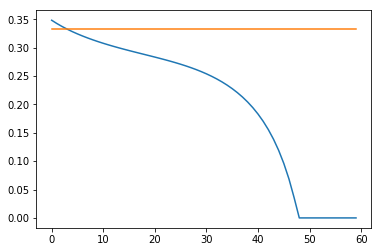

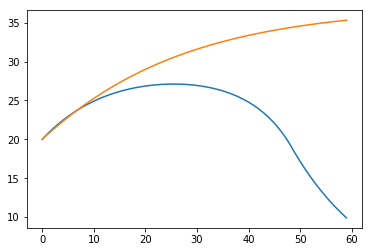

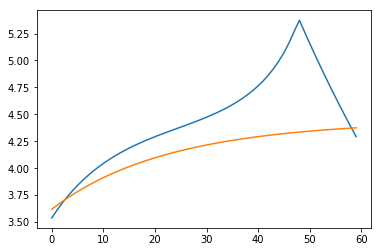

In [140]:
func.plot2(range(t),sks,sks_alt)
func.plot2(range(t),k/l,k_alt/l)
func.plot2(range(t),c/l,c_alt/l)

In [142]:
n = 50
ks = np.linspace(0.1,100,50)
sks1 = np.empty(50)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, l, weight, delta, alpha, theta, k)

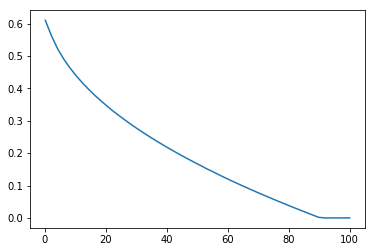

In [143]:
func.plot(ks,sks1)

In [147]:
n= 20
ks = np.linspace(1,600,20)
sks1 = np.empty(20)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, l, weight, delta, alpha, theta, k)

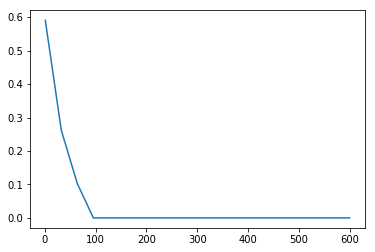

In [148]:
func.plot(ks,sks1)

In [150]:
ns = [-0.1,0,0.01,0.02,0.05,0.1,0.2]
sks1 = np.empty(len(ns))
for i,n in enumerate(ns):
    l = np.array([l0*(1+n)**i for i in range(t)])
    sks1[i] = optimal_sks(t, b, l, weight, delta, alpha, theta, k0)
    

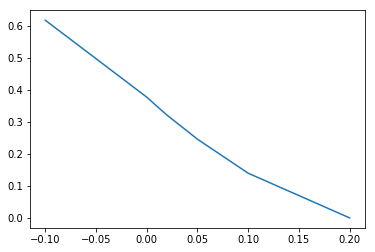

In [151]:
func.plot(ns,sks1)

# Need for speed

In [181]:
def tot_ut_multiple_sks1(sks, k0, l, b, weight, theta, alpha, delta, simple=True):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1],alpha,b)+(1-delta)*k_short[i-1]
    
    y_short = prod(k_short,l,alpha,b)
    if simple:
        return total_utility(y_short*(1-sks)/l, weight, theta)
    else:
        return total_utility(y_short*(1-sks)/l, weight, theta), y_short, y_short*(1-sks), k_short


def tot_ut_multiple_sks2(sks, k0, l, b, weight, theta, alpha, delta):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1],alpha,b)+(1-delta)*k_short[i-1]
    
    y_short = prod(k_short,l,alpha,b)
    
    return total_utility(y_short*(1-sks)/l, weight, theta)


In [183]:
n = 0.005

In [185]:
t = 60
l = np.array([(1+n)**i for i in range(t)])
weight = np.array([beta**i for i in range(t)])
sks = np.full(t,alpha)
k = np.full(t,10)

In [187]:
times = 100

In [190]:
assert np.allclose(tot_ut_multiple_sks1(sks, k0, l, b, weight, theta, alpha, delta),tot_ut_multiple_sks2(sks, k0, l, b, weight, theta, alpha, delta))
                   
def loop1(times):
    for i in range(times):
        tot_ut_multiple_sks1(sks, k0, l, b, weight, theta, alpha, delta)
        
def loop2(times):
    for i in range(times):
        tot_ut_multiple_sks2(sks, k0, l, b, weight, theta, alpha, delta)

In [193]:
tot_ut_multiple_sks1(sks, k0, l, b, weight, theta, alpha, delta)

69.81521459073922

In [191]:
%timeit loop1(times)
%timeit loop2(times)

15.7 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.1 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [489]:
%lprun -f tot_ut_multiple_sks1 -f loop1 loop1(times)

Timer unit: 1e-06 s

Total time: 0.322696 s
File: <ipython-input-462-407e0d85146e>
Function: tot_ut_multiple_sks1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def tot_ut_multiple_sks1(sks, k0, l, b, beta, theta, alpha, delta, simple=True):
     2                                               '''
     3                                               Finds total utitilty for a set of years with a savingsrate for each year
     4                                               '''
     5      1000        929.0      0.9      0.3      t = len(sks)
     6      1000       3546.0      3.5      1.1      k_short = np.empty(t)
     7      1000       1266.0      1.3      0.4      k_short[0] = k0
     8                                               
     9     60000      34979.0      0.6     10.8      for i in range(1,t):    
    10     59000     207002.0      3.5     64.1          k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1

In [490]:
%lprun -f tot_ut_multiple_sks2 -f loop2 loop2(times)

Timer unit: 1e-06 s

Total time: 0.402293 s
File: <ipython-input-462-407e0d85146e>
Function: tot_ut_multiple_sks2 at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def tot_ut_multiple_sks2(sks, k0, l, b, beta, theta, alpha, delta):
    20                                               '''
    21                                               Finds total utitilty for a set of years with a savingsrate for each year
    22                                               '''
    23      1000       2368.0      2.4      0.6      t = len(sks)
    24      1000       4881.0      4.9      1.2      k_short = np.empty(t)
    25      1000       1583.0      1.6      0.4      k_short[0] = k0
    26                                               
    27     60000      46014.0      0.8     11.4      for i in range(1,t):    
    28     59000     249111.0      4.2     61.9          k_short[i]=sks[i-1]*prod(k_short[i-1],l[i-1],alpha,b)+(

In [195]:
def optimal_sks2(t, b, l, weight, delta, alpha, theta, k0, first=True):
    obj = lambda sks: -tot_ut_multiple_sks2(sks, k0, l, b, weight, theta, alpha, delta)
    sks0 = np.linspace(alpha,0,t)

    bounds = np.full((t,2),[0,1])
    res = optimize.minimize(obj, sks0, method='L-BFGS-B', bounds=bounds)
    if res.success == False:
        print('Optimization was sadly not succesfull')
    elif first:
        return res.x[0]
    else:
        return res.x

In [197]:
optimal_sks2(t, b, l, weight, delta, alpha, theta, k0)

0.362314505935358

In [199]:
optimal_sks(t, b, l, weight, delta, alpha, theta, k0)

0.3625014173834399

In [611]:
times = 5

In [202]:
assert np.allclose(tot_ut_multiple_sks_quick(optimal_sks(t, b, l, weight, delta, alpha, theta, k0, first =False), k0, l, b, weight, theta, alpha, delta),tot_ut_multiple_sks_quick(optimal_sks2(t, b, l, weight, delta, alpha, theta, k0, first =False), k0, l, b, weight, theta, alpha, delta))
    
def loop1(times):
    for i in range(times):
        optimal_sks(t, b, l, weight, delta, alpha, theta, k0)
        
def loop2(times):
    for i in range(times):
        optimal_sks2(t, b, l, weight, delta, alpha, theta, k0)

In [203]:
%timeit loop1(times)
%timeit loop2(times)

9.18 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.2 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [204]:
%lprun -f optimal_sks -f loop1 loop1(times)

Timer unit: 1e-06 s

Total time: 13.2655 s
File: <ipython-input-128-be530121cece>
Function: optimal_sks at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def optimal_sks(t, b, l, weight, delta, alpha, theta, k0, first=True):
     2       100        157.0      1.6      0.0      obj = lambda sks: -tot_ut_multiple_sks_quick(sks, k0, l, b, weight, theta, alpha, delta)
     3       100       6465.0     64.7      0.0      sks0 = np.linspace(alpha,0,t)
     4                                           
     5       100       1857.0     18.6      0.0      bounds = np.full((t,2),[0,1])
     6       100   13255164.0 132551.6     99.9      res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
     7       100       1414.0     14.1      0.0      if res.success == False:
     8                                                   print('Optimization was sadly not succesfull')
     9       100         89.0      0.9     